# GLM: Mini-batch ADVI on hierarchical regression model
Unlike Gaussian mixture models, (hierarchical) regression models have independent variables. These variables affect the likelihood function, but are not random variables. When using mini-batch, we should take care of that. 

In [1]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
import theano
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

data = pd.read_csv(pm.get_data('radon.csv'))

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())
total_size = len(data)

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


Here, 'log_radon_t' is a dependent variable, while 'floor_t' and 'county_idx_t' determine independent variable.  

In [2]:
import theano.tensor as tt

log_radon_t = pm.Minibatch(data.log_radon.values, 100)
floor_t = pm.Minibatch(data.floor.values, 100)
county_idx_t = pm.Minibatch(data.county_code.values, 100)

In [ ]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)

Intercept for each county, distributed around group mean mu_a. Above we just set mu and sd to a fixed value while here we plug in a common group distribution for all a and b (which are vectors of length n_counties).

In [ ]:
with hierarchical_model:
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)

Model prediction of radon level `a[county_idx]` translates to `a[0, 0, 0, 1, 1, ...]`, we thus link multiple household measures of a county to its coefficients.

In [9]:
with hierarchical_model:

    radon_est = a[county_idx_t] + b[county_idx_t] * floor_t

Finally, we specify the likelihood:

In [3]:
with hierarchical_model:
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100) 
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=log_radon_t, total_size=len(data))

Random variable 'radon_like', associated with 'log_radon_t', should be given to the function for ADVI to denote that as observations in the likelihood term. 

On the other hand, 'minibatches' should include the three variables above. 

Then, run ADVI with mini-batch. 

In [4]:
with hierarchical_model:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 1,123.9: 100%|██████████| 100000/100000 [00:27<00:00, 3653.22it/s]
Finished [100%]: Average Loss = 1,124


Check the trace of ELBO and compare the result with MCMC. 

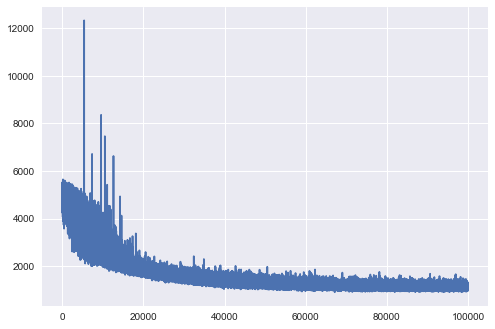

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(approx.hist)

In [6]:
# Inference button (TM)!
with pm.Model():

    mu_a = pm.Normal('mu_alpha', mu=0., sd=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sd=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)
    
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=n_counties)
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=n_counties)
    
    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal(
        'radon_like', mu=radon_est, sd=eps, observed=data.log_radon.values)
    
    step = pm.NUTS(scaling=approx.cov.eval(), is_cov=True)
    hierarchical_trace = pm.sample(2000, step, start=approx.sample()[0], progressbar=True)

100%|█████████▉| 2499/2500 [01:33<00:00, 55.31it/s] /Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:440: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.637204020924, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 0 contains 252 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [01:33<00:00, 26.77it/s]


In [7]:
means = approx.gbij.rmap(approx.mean.eval())
sds = approx.gbij.rmap(approx.std.eval())

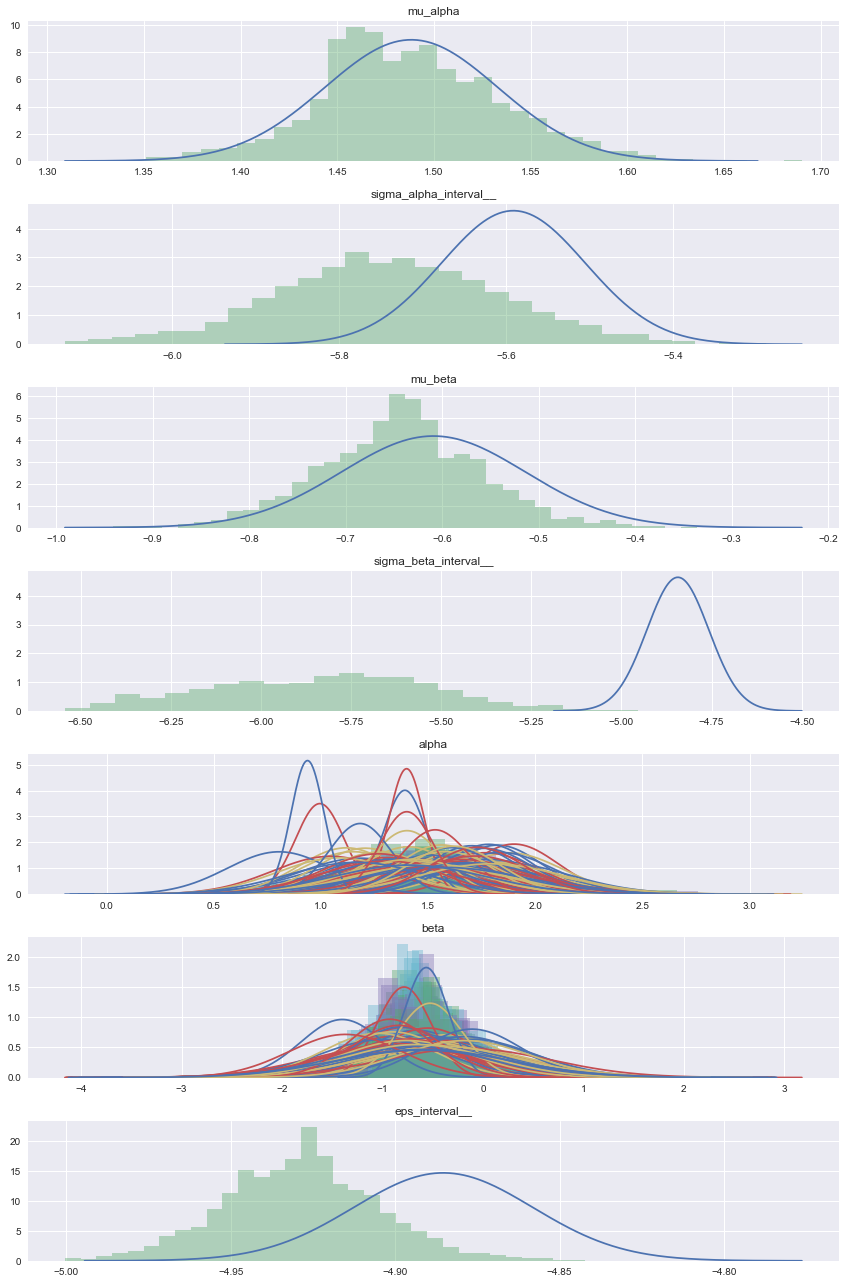

In [8]:
from scipy import stats
import seaborn as sns
varnames = means.keys()
fig, axs = plt.subplots(nrows=len(varnames), figsize=(12, 18))
for var, ax in zip(varnames, axs):
    mu_arr = means[var]
    sigma_arr = sds[var]
    ax.set_title(var)
    for i, (mu, sigma) in enumerate(zip(mu_arr.flatten(), sigma_arr.flatten())):
        sd3 = (-4*sigma + mu, 4*sigma + mu)
        x = np.linspace(sd3[0], sd3[1], 300)
        y = stats.norm(mu, sigma).pdf(x)
        ax.plot(x, y)
        if hierarchical_trace[var].ndim > 1:
            t = hierarchical_trace[var][i]
        else:
            t = hierarchical_trace[var]
        sns.distplot(t, kde=False, norm_hist=True, ax=ax)
fig.tight_layout()